In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255.0

X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

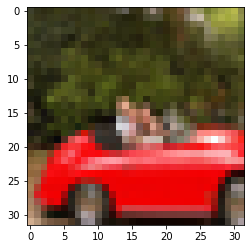

In [3]:
plt.imshow(X_train[99])

In [4]:
def mk_field(W, H):
    x = tf.range(0, 1, 1 / W)
    y = tf.range(0, 1, 1 / H)
    xx, yy = tf.meshgrid(x, y)

    xx = tf.reshape(xx, (-1,))
    yy = tf.reshape(yy, (-1,))
    field = tf.stack([xx, yy], axis=1)

    return field

In [37]:
def mk_model(depth, breadth):
    def block(u, a):
        return K.Sequential([
            K.layers.Dense(
                u,
                activation=a,
                kernel_initializer=tf.random_normal_initializer(0, 1),
                bias_initializer=tf.random_normal_initializer(0, 1)
            ),
            K.layers.BatchNormalization(),
        ])

    model = K.Sequential([
        K.layers.Input((2,)),
        *[block(breadth, a='tanh') for _ in range(depth)],
        K.layers.Dense(3, activation='sigmoid'),
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss=tf.losses.BinaryCrossentropy(label_smoothing=0),
    )

    return model


model = mk_model(depth=5, breadth=5)
model.count_params()

253

In [38]:
def mk_dataset(img, bs):
    W, H = img.shape[:2]

    inputs = mk_field(W, H)
    outputs = img.reshape(-1, 3)

    ds = tf.data.Dataset.from_tensors((inputs, outputs))
#     ds = ds.unbatch()
    ds = ds.repeat()
#     ds = ds.shuffle(W * H)
#     ds = ds.batch(W * H * bs)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds


dataset = mk_dataset(X_train[9999], bs=5)
X, y = next(dataset.as_numpy_iterator())
X.shape, y.shape

((1024, 2), (1024, 3))

In [39]:
def sample(model, W, H):
    field = mk_field(W, H)
    output = model(field)
    return tf.reshape(output, (W, H, -1)).numpy()

def show_sample(model, W, H, s=5):
    upscaled = sample(model, W, H)
    fig, ax = plt.subplots(figsize=(s, s))
    ax.imshow(upscaled)
    plt.show()

In [40]:
def on_epoch_begin(cb):
    class EndCallback(K.callbacks.Callback):
        def on_epoch_begin(self, batch, logs=None):
            cb()

    return EndCallback()


def on_batch_begin(cb):
    class EndCallback(K.callbacks.Callback):
        def on_batch_begin(self, batch, logs=None):
            cb()

    return EndCallback()

In [41]:
def normalize(video):
    min = np.min(video)
    max = np.max(video)
    np_version = np.array(((video - min) / (max - min) * 255.0))

    return np_version.astype(np.uint8)

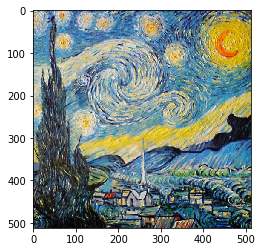

In [63]:
avatar_im = cv2.imread('starry_night.jpg')
avatar_im = cv2.cvtColor(avatar_im, cv2.COLOR_BGR2RGB) / 255.0
avatar_im = cv2.resize(avatar_im, (512, 512))
plt.imshow(avatar_im)

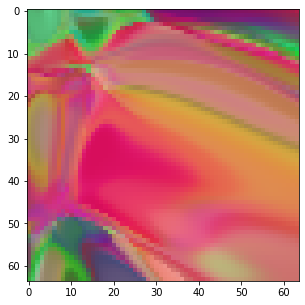

In [64]:
model = mk_model(depth=8, breadth=21)
show_sample(model, 64, 64)

Train for 64 steps


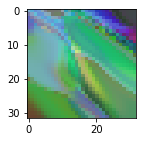

Epoch 1/2
64/64 [==============================] - 3s 54ms/step - loss: 0.5907


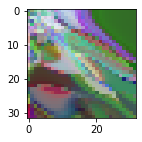

Epoch 2/2
64/64 [==============================] - 2s 38ms/step - loss: 0.4835


In [44]:
model.fit(
    mk_dataset(avatar_im, bs=1),
    steps_per_epoch=64,
    epochs=2,
    callbacks=[on_epoch_begin(lambda: show_sample(model, 32, 32, s=2))]
)

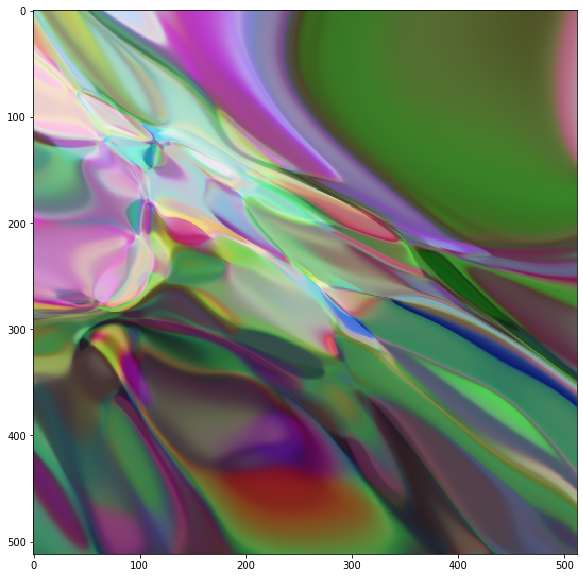

In [45]:
show_sample(model, 512, 512, s=10)

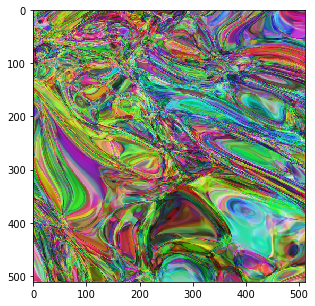

In [69]:
model = mk_model(depth=12, breadth=50)
show_sample(model, 512, 512)

In [ ]:
target_img = avatar_im  # X_train[99]
scale = 2
name = './test_13.avi'

actual_W, actual_H = target_img.shape[:2]
target_W, target_H = actual_W * scale, actual_H * scale

fourcc = cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(name, fourcc, 30, (target_W * 2, target_H))

field = mk_field(target_W, target_H)
target_img_scaled = normalize(cv2.resize(target_img, (target_W, target_H), cv2.INTER_NEAREST))

def batch_begin():
    output = model(field)
    output = tf.reshape(output, (target_W, target_H, -1))
    normalilzed_output = normalize(output)
    split_frame = np.concatenate((target_img_scaled, normalilzed_output), axis=1)
    split_frame = cv2.cvtColor(split_frame, cv2.COLOR_RGB2BGR)
    video.write(split_frame)

frames = 256

model.fit(
    mk_dataset(target_img, bs=4),
    steps_per_epoch=2048 / frames,
    epochs=frames,
    callbacks=[
#         on_epoch_begin(lambda: show_sample(model, 32, 32, s=2)),
        on_epoch_begin(batch_begin),
    ],
)

video.release()

Train for 8.0 steps
Epoch 1/256
8/8 [==============================] - 2s 238ms/step - loss: 0.8279
Epoch 2/256
8/8 [==============================] - 1s 106ms/step - loss: 0.7966
Epoch 3/256
8/8 [==============================] - 1s 106ms/step - loss: 0.7763
Epoch 4/256
8/8 [==============================] - 1s 106ms/step - loss: 0.7590
Epoch 5/256
8/8 [==============================] - 1s 118ms/step - loss: 0.7467
Epoch 6/256
8/8 [==============================] - 1s 118ms/step - loss: 0.7385
Epoch 7/256
8/8 [==============================] - 1s 127ms/step - loss: 0.7301
Epoch 8/256
8/8 [==============================] - 1s 128ms/step - loss: 0.7220
Epoch 9/256
8/8 [==============================] - 1s 127ms/step - loss: 0.7164
Epoch 10/256
8/8 [==============================] - 1s 127ms/step - loss: 0.7126
Epoch 11/256
8/8 [==============================] - 1s 127ms/step - loss: 0.7093
Epoch 12/256
8/8 [==============================] - 1s 119ms/step - loss: 0.7056
Epoch 13/256
8/8 